In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import pickle
import json
from matplotlib import pyplot as plt


# Helper functions

In [2]:
# function to infer labels from other labels
# this includes broader levels in the hierarchy from leave nodes, but also related labels (such 'phylogenetic' from 'phylo_sd')
def propagate_hierarchy(pred_df, classif):
    """Return a copy where every parent/cross-link label is made 1
       if any of its children are 1."""
    out = pred_df.copy()

    def recurse(node):
        if isinstance(node, dict):
            for parent, children in node.items():
                recurse(children)
                child_keys = []
                for c in children:
                    if isinstance(c, str):
                        child_keys.append(c)
                    elif isinstance(c, dict):
                        child_keys.extend(c.keys())
                if child_keys:
                    out.loc[out[child_keys].eq(1).any(axis=1), parent] = 1
        elif isinstance(node, list):
            for item in node:
                recurse(item)

    recurse(classif)

    # cross-links outside the hierarchical classification
    if {'interbr_morph','gen_interbr','interbreeding'}.issubset(out):
        mask = (out.interbr_morph==1)|(out.gen_interbr==1)
        out.loc[mask, 'interbreeding'] = 1

    if {'distance_based','distance'}.issubset(out):
        out.loc[out.distance_based==1, 'distance'] = 1

    if {'phen_pylo','phylo_sd','phylo_tree','phylogenetic'}.issubset(out):
        mask = (out.phen_pylo==1)|(out.phylo_sd==1)|(out.phylo_tree==1)
        out.loc[mask, 'phylogenetic'] = 1

    return out

# Prepare data for modelling

In [4]:
# load list with categories of interest
filename = r"categories_of_interest.txt"
with open(filename, 'r') as file:
    cats = json.load(file)

# hierarchical classification of the categories
filename = r"classification_categories.txt"
with open(filename, "r") as file:
    classif = json.load(file)


# get scibert model evaluation results
with open("scibert_results_df_NO_SCALING.pkl", "rb") as f:
    scibert_df = pickle.load(f)

scibert_df['id']

0      ./Corpus/EJT/10_5852_ejt_2021_735_1243.json_0
1       ./Corpus/Zootaxa/4/3/zootaxa_4312_3_5.json_0
2       ./Corpus/Zootaxa/4/3/zootaxa_4312_3_3.json_0
3      ./Corpus/EJT/10_5852_ejt_2021_771_1503.json_2
4       ./Corpus/Zootaxa/3/7/zootaxa_3785_4_6.json_0
                           ...                      
299       ./Corpus/Zootaxa/2/zootaxa_2241_1_1.json_0
300    ./Corpus/EJT/10_5852_ejt_2022_794_1661.json_4
301          ./Corpus/Pensoft/zookeys-833-121.json_0
302     ./Corpus/Zootaxa/4/4/zootaxa_4433_2_4.json_1
303          ./Corpus/Pensoft/zookeys-572-071.json_0
Name: id, Length: 304, dtype: object

In [5]:
# get predictions

# check for duplicate rows
scibert_df = scibert_df.drop_duplicates(subset='id', keep='first')

# extract the logits from the model
logits = scibert_df[[f"{i}_logit" for i in cats]].copy()

# give each column original label name
logits = logits.rename(columns = {f"{i}_logit":i for i in cats })

# turn logits into probabilities, then into predicted 1/0
probs = 1 / (1 + np.exp(-logits))
preds = (probs >= 0.5).astype(int)

# Enforce hierarchical consistency between labels, then fill missing values with 0 and convert to int
preds  = propagate_hierarchy(preds, classif).fillna(0).astype(int)

# add identifiers
preds['id'] = scibert_df['id'].values
preds['paper_id'] = scibert_df['paper_id'].values

# turn from paragraph level into paper level
preds_papers = (
    preds
    .groupby('paper_id')[cats]
    .max()
    .reset_index()
)

# inspect
print(preds_papers.shape)
preds_papers.head()


(298, 39)


,paper_id,phenotype,phen_data,morph,biogeo,color_pattern,phen_proc,imaging,quant_morph,storage,...,behav,phylogenetic,rank_just,phen_pylo,distance_based,acoustic,phylo_sd,interbreeding,specimen_storage_loc,abbrev_terms
0,./Corpus/EJT/10_5852_ejt_2012_13,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,./Corpus/EJT/10_5852_ejt_2017_309,1,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,./Corpus/EJT/10_5852_ejt_2017_341,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,./Corpus/EJT/10_5852_ejt_2017_382,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,./Corpus/EJT/10_5852_ejt_2017_386,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# get true (annotated) values
true = scibert_df[cats].copy()

# add identifiers
true['id'] = scibert_df['id'].values
true['paper_id'] = scibert_df['paper_id'].values

# turn from paragraph level into paper level
true_papers = (
    true
    .groupby('paper_id')[cats]
    .max()
    .reset_index()
)

# inspect
print(true_papers.shape)
true_papers.head()


(298, 39)


,paper_id,phenotype,phen_data,morph,biogeo,color_pattern,phen_proc,imaging,quant_morph,storage,...,behav,phylogenetic,rank_just,phen_pylo,distance_based,acoustic,phylo_sd,interbreeding,specimen_storage_loc,abbrev_terms
0,./Corpus/EJT/10_5852_ejt_2012_13,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,./Corpus/EJT/10_5852_ejt_2017_309,1,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,./Corpus/EJT/10_5852_ejt_2017_341,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,./Corpus/EJT/10_5852_ejt_2017_382,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,./Corpus/EJT/10_5852_ejt_2017_386,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# get total corpus info

filepath = r'methods_full_corpus_prediction.csv'
total_corpus_preds = pd.read_csv(filepath)
total_corpus_preds.columns

agg_pred_unseen = total_corpus_preds.groupby("paper")[cats].max() # paper level df
N_papers = len(agg_pred_unseen) # size of the corpus of papers with methods
S_pos    = agg_pred_unseen.sum().values           # predicted sum of positives for each label (shape 38,)



In [11]:
# build paper-level confusion counts 
pred_cols = [f"pred_{c}" for c in cats]
true_cols = [f"true_{c}" for c in cats]

agg_pred_test = preds_papers[cats]
agg_true_test = true_papers[cats]


TP = ((agg_true_test == 1) & (agg_pred_test == 1)).sum().values
FP = ((agg_true_test == 0) & (agg_pred_test == 1)).sum().values
FN = ((agg_true_test == 1) & (agg_pred_test == 0)).sum().values
TN = ((agg_true_test == 0) & (agg_pred_test == 0)).sum().values   # not used here

assert len(TP) == len(cats) == len(S_pos)  # must be 38


# Model 1: empirically informed priors

In [12]:
# bayesian model to estimate pred_p
L = len(cats)
with pm.Model() as m:
    tpr = pm.Beta("tpr", TP + 0.5, FN + 0.5, shape=L)
    fpr = pm.Beta("fpr", FP + 0.5, TN + 0.5, shape=L)
    pi  = pm.Beta("pi",  1, 1,      shape=L)

    pred_p = pm.Deterministic("pred_p", pi * tpr + (1 - pi) * fpr)
    S_observed = pm.Binomial("S", n=N_papers, p=pred_p, observed=S_pos)

    trace = pm.sample(500, chains=4, target_accept=0.95, progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpr, fpr, pi]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 36 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [22]:
# stack chain+draw → single 'sample' dim
pi_da = trace.posterior["pi"].stack(sample=("chain", "draw"))  

# rename the anonymous label dim to label
pi_da = pi_da.rename({"pi_dim_0": "label"})
pi_da = pi_da.assign_coords(label=cats)

# transpose so shape = (label , sample)  →  (L , draws) 
pi_draws = pi_da.transpose("label", "sample").values

# convert prevalence draws to true-paper count draws
count_draws = pi_draws * N_papers         

ci_lo  = np.percentile(count_draws,  2.5, axis=1)
ci_hi  = np.percentile(count_draws, 97.5, axis=1)
post_mean = count_draws.mean(axis=1)

paper_counts = pd.DataFrame({
    "Pred_Pos":  S_pos,
    "Post_mean": post_mean.round(1),
    "CI_lo":     ci_lo.round(1),
    "CI_hi":     ci_hi.round(1),
}, index=cats)

paper_counts.head(10)

,Pred_Pos,Post_mean,CI_lo,CI_hi
phenotype,28020,28032.7,27936.4,28228.5
phen_data,27149,26893.6,26613.8,27219.7
morph,26123,26170.3,26033.0,26422.9
biogeo,4142,4411.4,3985.2,5750.4
color_pattern,3659,3726.5,3461.7,4189.0
phen_proc,25843,25878.3,25720.2,26159.2
imaging,19269,19326.3,19097.2,19695.0
quant_morph,15148,15184.0,14952.3,15486.9
storage,16913,16951.0,16718.2,17241.6
sampling,12182,12220.2,11961.2,12575.9


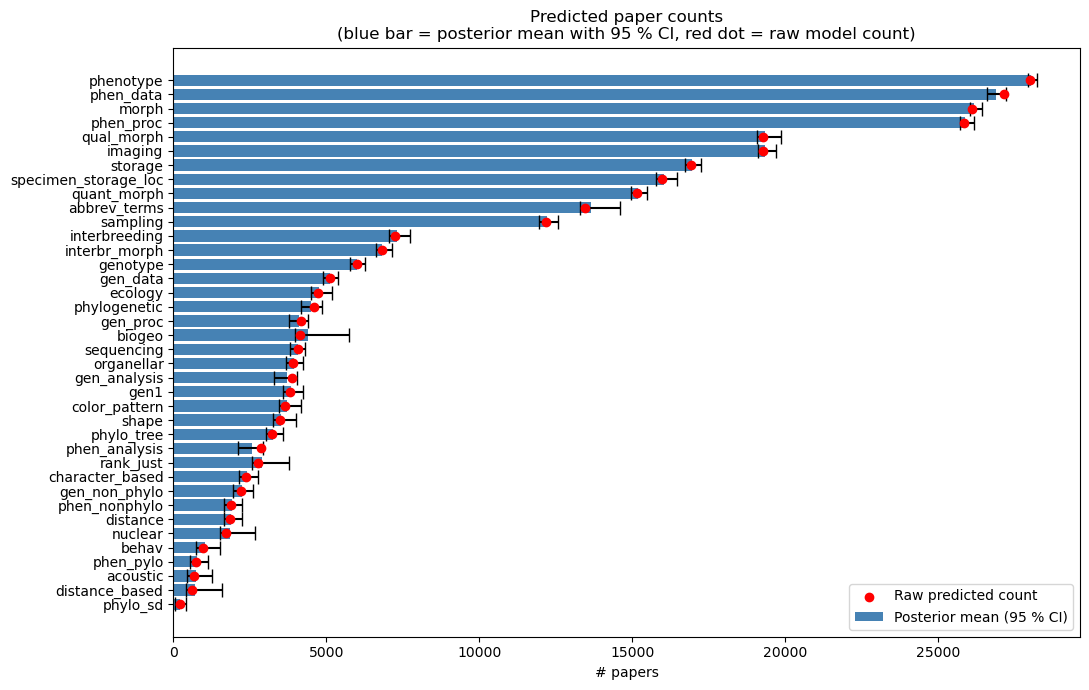

In [23]:
# plot the estimated counts

plot_df = paper_counts.sort_values("Pred_Pos", ascending=False)

y = np.arange(len(plot_df))

fig, ax = plt.subplots(figsize=(11, 7))

# posterior mean + credible interval
centre = plot_df["Post_mean"]
err_lo = centre - plot_df["CI_lo"]
err_hi = plot_df["CI_hi"] - centre

ax.barh(
    y,
    centre,
    xerr=[err_lo, err_hi],
    capsize=5,
    color="steelblue",
    label="Posterior mean (95 % CI)",
)

# red dot at the observed model count
ax.scatter(
    plot_df["Pred_Pos"],
    y,
    color="red",
    zorder=3,
    label="Raw predicted count",
)

# cosmetics
ax.set_yticks(y)
ax.set_yticklabels(plot_df.index)
ax.invert_yaxis()
ax.set_xlabel("# papers")
ax.set_title(
    "Predicted paper counts\n"
    "(blue bar = posterior mean with 95 % CI, red dot = raw model count)"
)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

Sampling: [S]


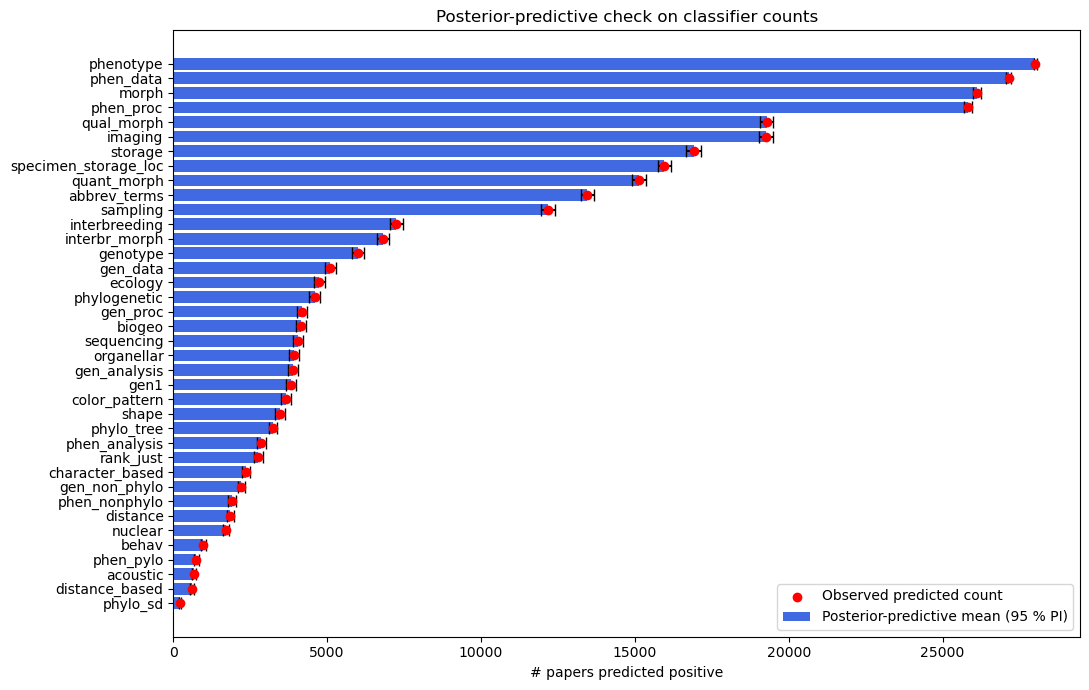

In [24]:
# Get posterior-predictive draws for the number of predicted positives
with m:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["S"], progressbar=False
    )

S_rep = (
    ppc.posterior_predictive["S"]
       .stack(sample=("chain", "draw"))      # dims: (label_idx , sample)
       # .assign_coords(label=cats)
)

# stats per label
pp_mean = S_rep.mean(dim="sample").values
pp_lo   = S_rep.quantile(0.025, dim="sample").values
pp_hi   = S_rep.quantile(0.975, dim="sample").values

pp_df = pd.DataFrame({
    "S_obs":   S_pos,           # raw red-dot count
    "PP_mean": pp_mean,
    "PP_lo":   pp_lo,
    "PP_hi":   pp_hi,
}, index=cats).sort_values("S_obs", ascending=False)

# Plot posterior-predictive vs observed

y = np.arange(len(pp_df))

fig, ax = plt.subplots(figsize=(11, 7))

# blue bar = posterior-predictive mean
ax.barh(
    y,
    pp_df["PP_mean"],
    xerr=[pp_df["PP_mean"] - pp_df["PP_lo"],
          pp_df["PP_hi"]  - pp_df["PP_mean"]],
    capsize=4,
    color="royalblue",
    label="Posterior-predictive mean (95 % PI)",
)

# red dot = observed classifier count
ax.scatter(
    pp_df["S_obs"],
    y,
    color="red",
    zorder=3,
    label="Observed predicted count",
)

ax.set_yticks(y)
ax.set_yticklabels(pp_df.index)
ax.invert_yaxis()
ax.set_xlabel("# papers predicted positive")
ax.set_title("Posterior-predictive check on classifier counts")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

## try uncertainty throughout

In [18]:
# also possible to model the entire process, rather than putting the counts into the priors directly
# this might solve the divergences, and propagates uncertainty

N_per_label = TP + FN + FP + TN  # length L

with pm.Model() as m_full:
    tpr = pm.Beta("tpr", 0.5, 0.5, shape=L)
    fpr = pm.Beta("fpr", 0.5, 0.5, shape=L)
    pi  = pm.Beta("pi",  1.0, 1.0,  shape=L)

    pm.Binomial("A_pos", n=N_per_label, p=pi, observed=TP+FN)
    pm.Binomial("TP_obs", n=TP+FN, p=tpr, observed=TP)
    pm.Binomial("FP_obs", n=FP+TN, p=fpr, observed=FP)

    pred_p = pm.Deterministic("pred_p", pi * tpr + (1 - pi) * fpr)

    # S: predicted-positive count per label
    pm.Binomial("S", n=N_papers, p=pred_p, observed=S_pos)

    trace_full = pm.sample(tune = 1000, draws = 1000, chains=4, target_accept=0.97, progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpr, fpr, pi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


In [19]:
# stack chain+draw → single 'sample' dim
pi_da = trace_full.posterior["pi"].stack(sample=("chain", "draw"))  

# rename the anonymous label dim to label
pi_da = pi_da.rename({"pi_dim_0": "label"})
pi_da = pi_da.assign_coords(label=cats)

# transpose so shape = (label , sample)  →  (L , draws) 
pi_draws = pi_da.transpose("label", "sample").values

# convert prevalence draws to true-paper count draws
count_draws = pi_draws * N_papers         

ci_lo  = np.percentile(count_draws,  2.5, axis=1)
ci_hi  = np.percentile(count_draws, 97.5, axis=1)
post_mean = count_draws.mean(axis=1)

paper_counts = pd.DataFrame({
    "Pred_Pos":  S_pos,
    "Post_mean": post_mean.round(1),
    "CI_lo":     ci_lo.round(1),
    "CI_hi":     ci_hi.round(1),
}, index=cats)

paper_counts.head(10)

,Pred_Pos,Post_mean,CI_lo,CI_hi
phenotype,28020,27528.4,26985.1,27858.9
phen_data,27149,25527.5,24678.0,26220.4
morph,26123,26018.3,25782.2,26153.1
biogeo,4142,3931.3,3162.1,4281.4
color_pattern,3659,3596.3,3254.5,3828.4
phen_proc,25843,25570.4,25136.2,25802.3
imaging,19269,19125.1,18749.4,19347.6
quant_morph,15148,15059.9,14732.1,15297.1
storage,16913,16798.9,16455.0,17038.8
sampling,12182,12090.5,11764.3,12316.7


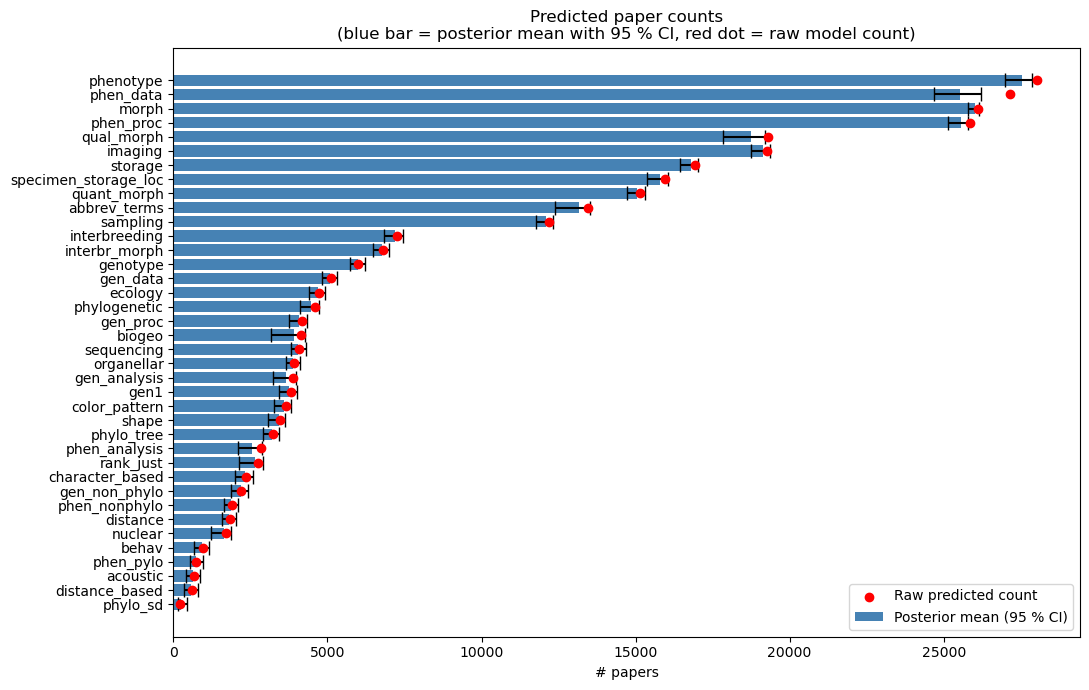

In [20]:
# plot the estimated counts

plot_df = paper_counts.sort_values("Pred_Pos", ascending=False)

y = np.arange(len(plot_df))

fig, ax = plt.subplots(figsize=(11, 7))

# posterior mean + credible interval
centre = plot_df["Post_mean"]
err_lo = centre - plot_df["CI_lo"]
err_hi = plot_df["CI_hi"] - centre

ax.barh(
    y,
    centre,
    xerr=[err_lo, err_hi],
    capsize=5,
    color="steelblue",
    label="Posterior mean (95 % CI)",
)

# red dot at the observed model count
ax.scatter(
    plot_df["Pred_Pos"],
    y,
    color="red",
    zorder=3,
    label="Raw predicted count",
)

# cosmetics
ax.set_yticks(y)
ax.set_yticklabels(plot_df.index)
ax.invert_yaxis()
ax.set_xlabel("# papers")
ax.set_title(
    "Predicted paper counts\n"
    "(blue bar = posterior mean with 95 % CI, red dot = raw model count)"
)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

Sampling: [S]


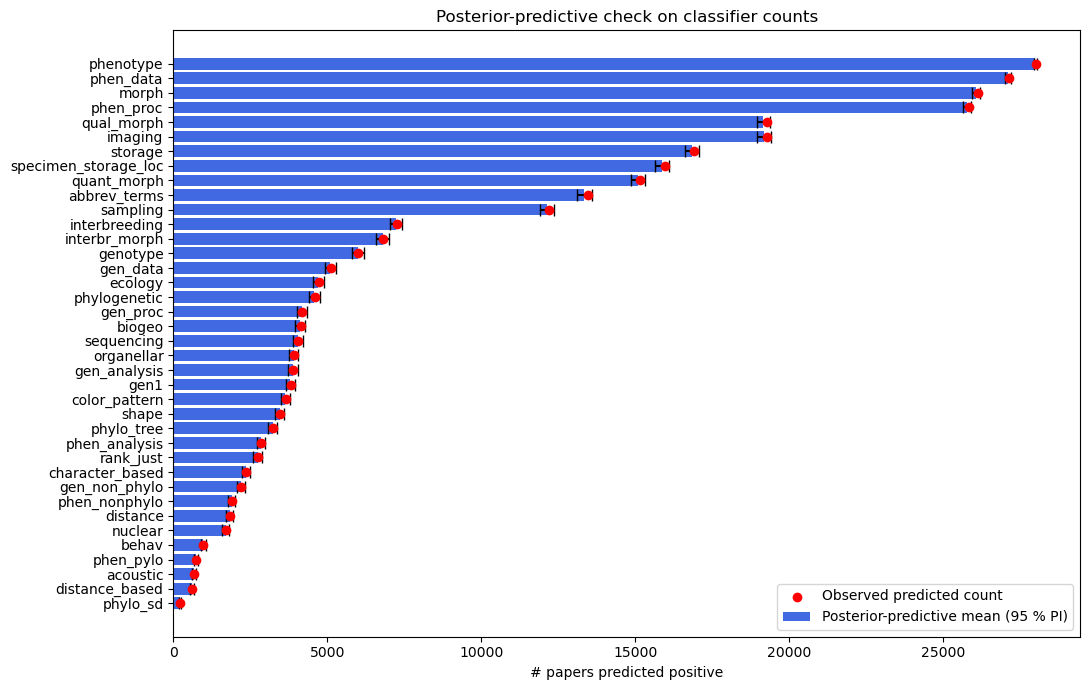

In [21]:
# Get posterior-predictive draws for the number of predicted positives
with m_full:
    ppc = pm.sample_posterior_predictive(
        trace_full, var_names=["S"], progressbar=False
    )

S_rep = (
    ppc.posterior_predictive["S"]
       .stack(sample=("chain", "draw"))      # dims: (label_idx , sample)
       # .assign_coords(label=cats)
)

# stats per label
pp_mean = S_rep.mean(dim="sample").values
pp_lo   = S_rep.quantile(0.025, dim="sample").values
pp_hi   = S_rep.quantile(0.975, dim="sample").values

pp_df = pd.DataFrame({
    "S_obs":   S_pos,           # raw red-dot count
    "PP_mean": pp_mean,
    "PP_lo":   pp_lo,
    "PP_hi":   pp_hi,
}, index=cats).sort_values("S_obs", ascending=False)

# Plot posterior-predictive vs observed

y = np.arange(len(pp_df))

fig, ax = plt.subplots(figsize=(11, 7))

# blue bar = posterior-predictive mean
ax.barh(
    y,
    pp_df["PP_mean"],
    xerr=[pp_df["PP_mean"] - pp_df["PP_lo"],
          pp_df["PP_hi"]  - pp_df["PP_mean"]],
    capsize=4,
    color="royalblue",
    label="Posterior-predictive mean (95 % PI)",
)

# red dot = observed classifier count
ax.scatter(
    pp_df["S_obs"],
    y,
    color="red",
    zorder=3,
    label="Observed predicted count",
)

ax.set_yticks(y)
ax.set_yticklabels(pp_df.index)
ax.invert_yaxis()
ax.set_xlabel("# papers predicted positive")
ax.set_title("Posterior-predictive check on classifier counts")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()